# A generational model of gun ownership and gun control

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rc('figure', figsize=(4, 3))

import seaborn as sns
sns.set(style='white', font_scale=1.5, context='talk')
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')

from collections import Counter
from statsmodels.discrete.discrete_model import MNLogit
from statsmodels.discrete.discrete_model import Logit

## Loading and validation

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

You can get my selected subset of variables from https://gssdataexplorer.norc.org/projects/41723#

In [2]:
def make_boolean(df, varname, values, newvar):
    df[newvar] = df[varname].isin(values)
    df.loc[gss[varname].isnull(), newvar] = np.nan

In [3]:
gss = utils.ReadGss('gss_gun')
print(gss.shape)
gss.head()

(62466, 20)


,year,owngun,rowngun,conrinc,cohort,ballot,wtssall,income,finrela,gunnum,gunage,id_,age,race,srcbelt,polviews,natcrime,gunlaw,gun,realinc
0,1972,0,0,0.0,1949,0,0.4446,0,3,0,0,1,23,1,3,0,0,1,0,18951.0
1,1972,0,0,0.0,1902,0,0.8893,0,4,0,0,2,70,1,3,0,0,1,0,24366.0
2,1972,0,0,0.0,1924,0,0.8893,0,3,0,0,3,48,1,3,0,0,1,0,24366.0
3,1972,0,0,0.0,1945,0,0.8893,0,3,0,0,4,27,1,3,0,0,1,0,30458.0
4,1972,0,0,0.0,1911,0,0.8893,0,4,0,0,5,61,1,3,0,0,1,0,50763.0


### Variable `gunlaw`

Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?

https://gssdataexplorer.norc.org/projects/41723/variables/272/vshow

In [4]:
gss.gunlaw.replace([8, 9, 0], np.nan, inplace=True)
sum(~gss.gunlaw.isnull())

40472

In [5]:
utils.values(gss, 'gunlaw')

1.0    30936
2.0     9536
Name: gunlaw, dtype: int64

In [6]:
make_boolean(gss, 'gunlaw', [1.0], 'favor')
utils.values(gss, 'favor')

0.0     9536
1.0    30936
Name: favor, dtype: int64

### Variable `owngun`

Do you happen to have in your home (IF HOUSE: or garage) any guns or revolvers?

https://gssdataexplorer.norc.org/projects/41723/variables/679/vshow

In [7]:
gss.owngun.replace([3, 8, 9, 0], np.nan, inplace=True)
sum(~gss.owngun.isnull())

37640

In [8]:
utils.values(gss, 'owngun')

1.0    15122
2.0    22518
Name: owngun, dtype: int64

In [9]:
make_boolean(gss, 'owngun', [1.0], 'gunhome')
utils.values(gss, 'gunhome')

0.0    22518
1.0    15122
Name: gunhome, dtype: int64

### Variable `gun`

Have you ever been threatened with a gun, or shot at? 

https://gssdataexplorer.norc.org/projects/41723/variables/661/vshow

In [10]:
gss.gun.replace([8, 9, 0], np.nan, inplace=True)
sum(~gss.gun.isnull())

19328

In [11]:
utils.values(gss, 'gun')

1.0     3775
2.0    15553
Name: gun, dtype: int64

In [12]:
make_boolean(gss, 'gun', [1.0], 'threatened')
utils.values(gss, 'threatened')

0.0    15553
1.0     3775
Name: threatened, dtype: int64

### Variable `natcrime`

We are faced with many problems in this country, none of which can be solved easily or inexpensively. I'm going to name some of these problems, and for each one I'd like you to name some of these problems, and for each one I'd like you to tell me whether you think we're spending too much money on it, too little money, or about the right amount. First (READ ITEM A) . . . are we spending too much, too little, or about the right amount on (ITEM)? 
E. Halting the rising crime rate

[Note: the wording of this question assumes that crime rates are rising!]

https://gssdataexplorer.norc.org/projects/41723/variables/185/vshow

In [13]:
gss.natcrime.replace([8, 9, 0], np.nan, inplace=True)
sum(~gss.natcrime.isnull())

34402

In [14]:
utils.values(gss, 'natcrime')

1.0    23200
2.0     9099
3.0     2103
Name: natcrime, dtype: int64

In [15]:
make_boolean(gss, 'natcrime', [1.0], 'spendcrime')
utils.values(gss, 'spendcrime')

0.0    11202
1.0    23200
Name: spendcrime, dtype: int64

### Variable `income`

In which of these groups did your total family income, from all sources, fall last year before taxes, that is?



In [16]:
varname = 'income'
gss[varname].replace([0, 13, 98, 99], np.nan, inplace=True)
sum(~gss[varname].isnull())

54505

In [17]:
utils.values(gss, varname)

1.0       762
2.0      1301
3.0      1253
4.0      1153
5.0      1267
6.0      1214
7.0      1268
8.0      2149
9.0      6354
10.0     4965
11.0     5047
12.0    27772
Name: income, dtype: int64

In [18]:
gss[varname].describe()

count    54505.000000
mean        10.036492
std          2.845831
min          1.000000
25%          9.000000
50%         12.000000
75%         12.000000
max         12.000000
Name: income, dtype: float64

In [19]:
make_boolean(gss, 'income', [12.0], 'topincome')
utils.values(gss, 'topincome')

0.0    26733
1.0    27772
Name: topincome, dtype: int64

In [20]:
make_boolean(gss, 'income', [1,2,3,4,5,6,7,8], 'lowincome')
utils.values(gss, 'lowincome')

0.0    44138
1.0    10367
Name: lowincome, dtype: int64

### Variable `realinc`




In [21]:
varname = 'realinc'
gss[varname].replace([0], np.nan, inplace=True)
sum(~gss[varname].isnull())

56141

In [22]:
gss[varname].describe()

count     56141.000000
mean      31636.199666
std       29402.370825
min         234.000000
25%       12080.625000
50%       24097.500000
75%       39022.500000
max      162607.000000
Name: realinc, dtype: float64

In [23]:
per25 = gss[varname].quantile(0.25)
per75 = gss[varname].quantile(0.75)
per25, per75

(12080.625, 39022.5)

In [24]:
gss['lowinc'] = gss[varname] <= per25 
gss.loc[gss[varname].isnull(), 'lowinc'] = np.nan
utils.values(gss, 'lowinc')

0.0    42062
1.0    14079
Name: lowinc, dtype: int64

In [25]:
gss['highinc'] = gss[varname] >= per75 
gss.loc[gss[varname].isnull(), 'highinc'] = np.nan
utils.values(gss, 'highinc')

0.0    41963
1.0    14178
Name: highinc, dtype: int64

### Variable `polviews`


A. We hear a lot of talk these days about liberals and conservatives. 
I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

https://gssdataexplorer.norc.org/projects/41723/variables/178/vshow

In [26]:
varname = 'polviews'
gss[varname].replace([8, 9, 0], np.nan, inplace=True)
sum(~gss[varname].isnull())

53081

In [27]:
utils.values(gss, varname)

1.0     1560
2.0     6236
3.0     6754
4.0    20515
5.0     8407
6.0     7876
7.0     1733
Name: polviews, dtype: int64

In [28]:
def make_polviews(df):
    make_boolean(gss, 'polviews', [1,2,3], 'liberal')
    make_boolean(gss, 'polviews', [4], 'moderate')
    make_boolean(gss, 'polviews', [6,7,8], 'conservative')

make_polviews(gss)

In [29]:
utils.values(gss, 'liberal')

0.0    38531
1.0    14550
Name: liberal, dtype: int64

In [30]:
utils.values(gss, 'moderate')

0.0    32566
1.0    20515
Name: moderate, dtype: int64

In [31]:
utils.values(gss, 'conservative')

0.0    43472
1.0     9609
Name: conservative, dtype: int64

### Age 

https://gssdataexplorer.norc.org/projects/29853/variables/53/vshow

In [32]:
gss.age.replace([98, 99], np.nan, inplace=True)
sum(gss.age.isnull())

221

### Race

https://gssdataexplorer.norc.org/projects/41723/variables/82/vshow

CODE WITHOUT ASKING ONLY IF THERE IS NO DOUBT IN YOUR MIND. 
What race do you consider yourself? RECORD VERBATIM AND CODE.

In [33]:
sum(gss.race.isnull())

0

In [34]:
utils.values(gss, 'race')

1    50340
2     8802
3     3324
Name: race, dtype: int64

In [35]:
make_boolean(gss, 'race', [2], 'black')
utils.values(gss, 'black')

0.0    53664
1.0     8802
Name: black, dtype: int64

In [36]:
make_boolean(gss, 'race', [3], 'otherrace')
utils.values(gss, 'otherrace')

0.0    59142
1.0     3324
Name: otherrace, dtype: int64

### srcbelt

C. SRC (SURVEY RESEARCH CENTER, UNIVERSITY OF MICHIGAN) NEW BELT CODE

https://gssdataexplorer.norc.org/projects/41723/variables/121/vshow

In [37]:
sum(gss.srcbelt.isnull())

0

In [38]:
utils.values(gss, 'srcbelt')

1     5572
2     8670
3     7113
4     9348
5    23583
6     8180
Name: srcbelt, dtype: int64

In [39]:
make_boolean(gss, 'srcbelt', [1,2,5], 'urban')
utils.values(gss, 'urban')

0.0    24641
1.0    37825
Name: urban, dtype: int64

In [40]:
make_boolean(gss, 'srcbelt', [3,4], 'suburban')
utils.values(gss, 'suburban')

0.0    46005
1.0    16461
Name: suburban, dtype: int64

In [41]:
make_boolean(gss, 'srcbelt', [6], 'rural')
utils.values(gss, 'rural')

0.0    54286
1.0     8180
Name: rural, dtype: int64

### Year of birth 

https://gssdataexplorer.norc.org/projects/29853/variables/5507/vshow

In [42]:
gss.cohort.replace([9999], np.nan, inplace=True)
sum(gss.cohort.isnull())

221

Drop records if age or cohort is missing.

In [43]:
gss.dropna(subset=['age', 'cohort'], inplace=True)
gss.shape

(62244, 36)

We drop 222 records due to missing data.

In [44]:
62466 - 62244

222

Here's the distribution of ages.

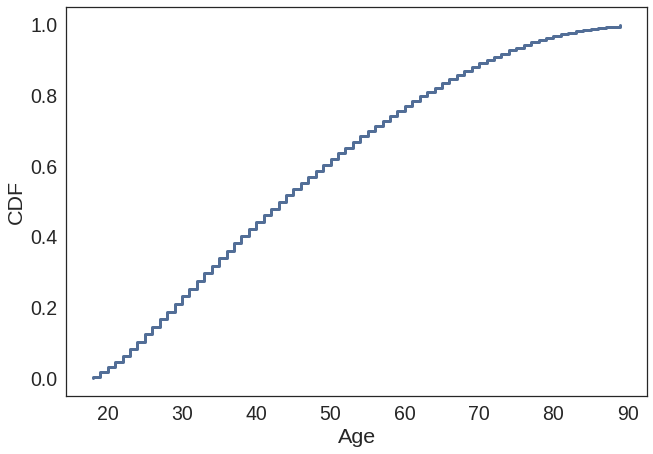

In [45]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

Group people into 5-year age groups.

In [46]:
gss['age_group'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5

Here's the distribution of birth year.

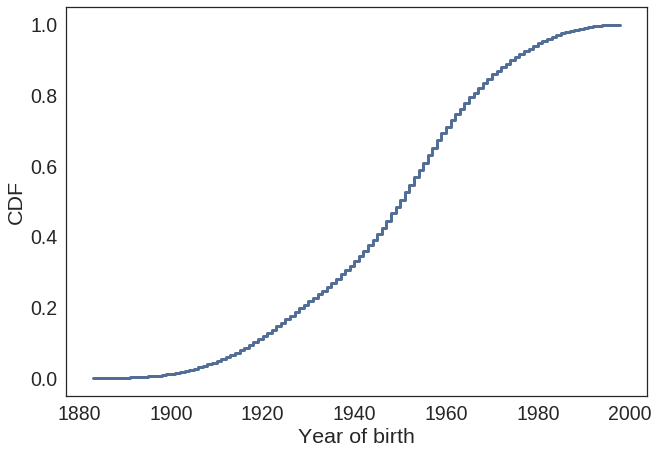

In [47]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

Group people into 5- and 10-year bins by birth year.

In [48]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5, low=2) + 2.5

In [49]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.gunlaw.count()
counts

cohort5
1884.5      15
1889.5      85
1894.5     216
1899.5     443
1904.5     722
1909.5    1089
1914.5    1500
1919.5    1837
1924.5    2145
1929.5    2146
1934.5    2328
1939.5    2616
1944.5    3336
1949.5    4254
1954.5    4150
1959.5    3717
1964.5    2935
1969.5    2230
1974.5    1644
1979.5    1266
1984.5     879
1989.5     560
1994.5     213
1999.5      13
Name: gunlaw, dtype: int64

To avoid a final data point with a small sample size, I chose `low` to minimize the number of people in the last group, and I've lumped them in with the previous group.

In [50]:
gss.loc[gss.cohort5==1999.5, 'cohort5'] = 1994.5
gss.loc[gss.cohort5<1894, 'cohort5'] = 1894.5

In [51]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.gunlaw.count()
counts

cohort5
1894.5     316
1899.5     443
1904.5     722
1909.5    1089
1914.5    1500
1919.5    1837
1924.5    2145
1929.5    2146
1934.5    2328
1939.5    2616
1944.5    3336
1949.5    4254
1954.5    4150
1959.5    3717
1964.5    2935
1969.5    2230
1974.5    1644
1979.5    1266
1984.5     879
1989.5     560
1994.5     226
Name: gunlaw, dtype: int64

In [52]:
gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)

In [53]:
grouped_cohort = gss.groupby(['cohort10'])
counts = grouped_cohort.gunlaw.count()
counts

cohort10
1880.0      53
1890.0     502
1900.0    1563
1910.0    3024
1920.0    4212
1930.0    4703
1940.0    6929
1950.0    8212
1960.0    5721
1970.0    3278
1980.0    1750
1990.0     392
Name: gunlaw, dtype: int64

Here's the number of respondents in each year.

In [54]:
utils.values(gss, 'year')

1972    1608
1973    1500
1974    1478
1975    1485
1976    1493
1977    1523
1978    1525
1980    1459
1982    1845
1983    1592
1984    1467
1985    1527
1986    1463
1987    1807
1988    1477
1989    1533
1990    1372
1991    1514
1993    1601
1994    2986
1996    2898
1998    2827
2000    2809
2002    2751
2004    2803
2006    4492
2008    2013
2010    2041
2012    1969
2014    2529
2016    2857
Name: year, dtype: int64

In [55]:
gss['year3'] = utils.RoundIntoBins(gss, 'year', 3, low=0) + 1.5
utils.values(gss, 'year3')

1972.5    3108
1975.5    4456
1978.5    3048
1981.5    3304
1984.5    4586
1987.5    4747
1990.5    4419
1993.5    4587
1996.5    2898
1999.5    5636
2002.5    2751
2005.5    7295
2008.5    2013
2011.5    4010
2014.5    2529
2017.5    2857
Name: year3, dtype: int64

In [56]:
gss['age3'] = utils.RoundIntoBins(gss, 'age', 3, low=0) + 1.5
utils.values(gss, 'age3')

19.5    1924
22.5    3238
25.5    3815
28.5    4023
31.5    4094
34.5    4033
37.5    3951
40.5    3609
43.5    3496
46.5    3217
49.5    3178
52.5    3019
55.5    2817
58.5    2681
61.5    2538
64.5    2289
67.5    2184
70.5    1913
73.5    1690
76.5    1418
79.5    1114
82.5     839
85.5     573
88.5     591
Name: age3, dtype: int64

In [57]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors to make the coeffients
    of the model easier to interpret.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['a'] = df.age - 47
    df['y'] = df.year - 1990
    
    # also add quadratic factors and interaction term
    df['c2'] = df.c**2
    df['a2'] = df.a**2
    df['y2'] = df.y**2
    df['ac'] = df.a * df.c
    
    df['cohort10'] = utils.RoundIntoBins(df, 'cohort', 10)
    df['twenties'] = (df.cohort10 == 1920.0).astype(int)
    df['thirties'] = (df.cohort10 == 1930.0).astype(int)
    df['forties'] = (df.cohort10 == 1940.0).astype(int)
    df['fifties'] = (df.cohort10 == 1950.0).astype(int)
    df['sixties'] = (df.cohort10 == 1960.0).astype(int)
    df['seventies'] = (df.cohort10 == 1970.0).astype(int)
    df['eighties'] = (df.cohort10 == 1980.0).astype(int)
    df['nineties'] = (df.cohort10 == 1990.0).astype(int)

In [58]:
center_factors(gss)

Recode some variables

## Resample

Resampling (bootstrapping to be more specific) to account for sampling weights.

In [59]:
sample = utils.ResampleByYear(gss)
sample.head()

,year,owngun,rowngun,conrinc,cohort,ballot,wtssall,income,finrela,gunnum,...,y2,ac,twenties,thirties,forties,fifties,sixties,seventies,eighties,nineties
0,1972,NaN,0,0.0,1950.0,0,2.6679,NaN,3,0,...,324,400.0,0,0,0,1,0,0,0,0
1,1972,NaN,0,0.0,1913.0,0,0.8893,NaN,4,0,...,324,-636.0,0,0,0,0,0,0,0,0
2,1972,NaN,0,0.0,1911.0,0,0.4446,NaN,3,0,...,324,-770.0,0,0,0,0,0,0,0,0
3,1972,NaN,0,0.0,1920.0,0,0.8893,NaN,2,0,...,324,-230.0,1,0,0,0,0,0,0,0
4,1972,NaN,0,0.0,1946.0,0,0.8893,NaN,3,0,...,324,420.0,0,0,1,0,0,0,0,0


In [60]:
def fill_missing_column(df, colname):
    """Fills missing values of the given column.

    df: DataFrame
    colname: string
    """
    null = df[df[colname].isnull()]

    print(len(null), len(df))

    valid = df[colname].dropna()
    fill = valid.sample(len(null), replace=True)
    fill.index = null.index

    df[colname].fillna(fill, inplace=True)

In [61]:
fill_missing_column(sample, 'y')

0 62244


In [62]:
fill_missing_column(sample, 'y2')

0 62244


In [63]:
fill_missing_column(sample, 'nineties')

0 62244


In [64]:
fill_missing_column(sample, 'threatened')

42974 62244


In [65]:
fill_missing_column(sample, 'gunhome')

24754 62244


In [66]:
fill_missing_column(sample, 'race')

0 62244


In [67]:
fill_missing_column(sample, 'srcbelt')

0 62244


In [68]:
fill_missing_column(sample, 'polviews')

9309 62244


In [69]:
make_polviews(sample)

In [70]:
fill_missing_column(sample, 'spendcrime')

27796 62244


### Run logistic models



In [71]:
sample.columns

Index(['year', 'owngun', 'rowngun', 'conrinc', 'cohort', 'ballot', 'wtssall',
       'income', 'finrela', 'gunnum', 'gunage', 'id_', 'age', 'race',
       'srcbelt', 'polviews', 'natcrime', 'gunlaw', 'gun', 'realinc', 'favor',
       'gunhome', 'threatened', 'spendcrime', 'topincome', 'lowincome',
       'lowinc', 'highinc', 'liberal', 'moderate', 'conservative', 'black',
       'otherrace', 'urban', 'suburban', 'rural', 'age_group', 'cohort5',
       'cohort10', 'year3', 'age3', 'ones', 'c', 'a', 'y', 'c2', 'a2', 'y2',
       'ac', 'twenties', 'thirties', 'forties', 'fifties', 'sixties',
       'seventies', 'eighties', 'nineties'],
      dtype='object')

In [72]:
utils.values(sample, 'threatened')

0.0    50161
1.0    12083
Name: threatened, dtype: int64

In [81]:
formula = ('favor ~ y + y2 + nineties + eighties + seventies + sixties + fifties + forties + thirties + '
           'black + otherrace + conservative + liberal + lowinc + highinc + urban + rural + '
           'threatened + gunhome ')
model = smf.logit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.509094
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  favor   No. Observations:                32387
Model:                          Logit   Df Residuals:                    32367
Method:                           MLE   Df Model:                           19
Date:                Tue, 06 Mar 2018   Pseudo R-squ.:                 0.06330
Time:                        17:04:10   Log-Likelihood:                -16488.
converged:                       True   LL-Null:                       -17602.
                                        LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.0360      0.051     39.650      0.000       1.935       2.137
y                0.0112      0.002      7.348      0.000       0.008       0.014
y2              -0.0011   9.19e-05    -11.918      0.000      -0.001      -0.001
nineties        -0.4869      0.127     -3.843      0.000      -0.735      -0.239
eighties        -0.2464      0.077     -3.180      0.001      -0.398      -0.095
seventies       -0.1930      0.062     -3.120      0.002      -0.314      -0.072
sixties         -0.0109      0.052     -0.211      0.833      -0.112       0.091
fifties         -0.0781      0.045     -1.738      0.082      -0.166       0.010
forties         -0.0332      0.047     -0.703      0.482      -0.126       0.059
thirties         0.0130      0.051      0.256      0.798      -0.087       0.113
black            0.3367      0.045      7.445      0.000       0.248       0.425
otherrace        0.4439      0.073      6.099      0.000       0.301       0.587
conservative    -0.3717      0.035    -10.699      0.000      -0.440      -0.304
liberal          0.2978      0.034      8.690      0.000       0.231       0.365
lowinc          -0.2164      0.037     -5.850      0.000      -0.289      -0.144
highinc          0.1008      0.032      3.128      0.002       0.038       0.164
urban           -0.1707      0.033     -5.108      0.000      -0.236      -0.105
rural           -0.4459      0.046     -9.791      0.000      -0.535      -0.357
threatened      -0.1521      0.034     -4.518      0.000      -0.218      -0.086
gunhome         -0.9625      0.029    -33.074      0.000      -1.020      -0.905
================================================================================
"""

In [82]:
varnames = ('nineties', 'eighties', 'seventies', 'sixties', 'fifties', 'forties', 'thirties', 'black', 'otherrace',
            'threatened', 'gunhome', 'conservative', 'liberal', 'lowinc', 'highinc', 'urban', 'rural')

In [83]:
y = 2016 - 1990
y2 = y**2

d = dict(y=y, y2=y2, race=1)
for varname in varnames:
    d[varname] = 0

s = pd.Series(d)
s

black             0
conservative      0
eighties          0
fifties           0
forties           0
gunhome           0
highinc           0
liberal           0
lowinc            0
nineties          0
otherrace         0
race              1
rural             0
seventies         0
sixties           0
thirties          0
threatened        0
urban             0
y                26
y2              676
dtype: int64

In [84]:
df_pred = pd.DataFrame(columns=sample.columns)
df_pred

,year,owngun,rowngun,conrinc,cohort,ballot,wtssall,income,finrela,gunnum,...,y2,ac,twenties,thirties,forties,fifties,sixties,seventies,eighties,nineties


In [85]:
for varname in varnames:
    df_pred.loc[varname] = s
    df_pred.loc[varname, varname] = 1
    
df_pred.loc[:, varnames]

,nineties,eighties,seventies,sixties,fifties,forties,thirties,black,otherrace,threatened,gunhome,conservative,liberal,lowinc,highinc,urban,rural
nineties,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eighties,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
seventies,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sixties,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fifties,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
forties,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
thirties,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
otherrace,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
threatened,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
pred = model.predict(df_pred) * 100
pred

nineties        75.036000
eighties        79.266005
seventies       80.129890
sixties         82.871170
fifties         81.895985
forties         82.552211
thirties        83.208559
black           87.259802
otherrace       88.405448
threatened      80.773195
gunhome         65.134498
conservative    77.130949
liberal         86.820766
lowinc          79.755716
highinc         84.399906
urban           80.483383
rural           75.795612
dtype: float64

In [87]:
pred - pred['sixties']

nineties        -7.835170
eighties        -3.605165
seventies       -2.741281
sixties          0.000000
fifties         -0.975186
forties         -0.318959
thirties         0.337389
black            4.388632
otherrace        5.534278
threatened      -2.097975
gunhome        -17.736672
conservative    -5.740222
liberal          3.949596
lowinc          -3.115455
highinc          1.528736
urban           -2.387787
rural           -7.075558
dtype: float64

In [80]:
stop

NameError: name 'stop' is not defined

In [ ]:
def plot_series(grouped, varname, **options):
    series = grouped[varname].mean() * 100
    thinkplot.plot(series.dropna(), **options)
    thinkplot.config(xlabel='Year of survey', 
                     ylabel='Percent',
                     xlim=[1971, 2017])

In [ ]:
grouped_year3 = sample.groupby('year3')

In [ ]:
plot_series(grouped_year3, 'black')

In [ ]:
def model_predict(model, new):
    res = new.copy()
    res['pred'] = model.predict(new) * 100
    res['diff'] = res.pred - res.pred[0]
    return res[['cohort', 'age',  'pred', 'diff']]

In [ ]:
age = [46, 18, 46]
cohort = [1971, 2000, 2000]
new = pd.DataFrame(dict(age=age, cohort=cohort))
center_factors(new)

In [ ]:
model_predict(model, new)

In [ ]:
formula = 'favor ~ c + a + c2 + a2 + ac'
model = smf.logit(formula, data=sample).fit()
model.summary()

In [ ]:
age = [46, 18, 46]
cohort = [1971, 2000, 2000]
new = pd.DataFrame(dict(age=age, cohort=cohort))
center_factors(new)

In [ ]:
formula = 'favor ~ a + a2 + nineties + eighties + seventies + sixties + fifties + forties + thirties + twenties'
model = smf.logit(formula, data=sample).fit()
model.summary()

In [ ]:
model_predict(model, new)

In [ ]:
formula = 'gunhome ~ c + a'
model = smf.logit(formula, data=sample).fit()
model.summary()

In [ ]:
formula = 'gunhome ~ c + a + a2 + c2'
model = smf.logit(formula, data=sample).fit()
model.summary()

## Favor gunlaw

In [ ]:
def make_series(grouped, varname):
    """Compute the percentage in each category.
    
    grouped: GroupBy object
    varname: string column name
    
    returns:  Series
    """
    return grouped[varname].mean() * 100

In [ ]:
def plot_series(series, **options):
    """Plots Series objects.
    
    series: Series
    """
    thinkplot.plot(series.dropna(), **options)

In [ ]:
def plot_gunlaw(grouped):
    """.
    
    grouped:
    """
    varnames = ['favor']
    colors = [BLUE]
    labels = ['Favor']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

Plot the percentage in each religious group as a function of survey year.

In [ ]:
grouped_year = sample.groupby('year')
favor = make_series(grouped_year, 'favor')
favor

In [ ]:
plot_series(favor, color=BLUE, label='favor')
thinkplot.config(xlabel='Year of survey', 
                 ylabel='Percent',
                 xlim=[1971, 2017])

In [ ]:
crime = make_series(grouped_year, 'crime')
crime

In [ ]:
plot_series(crime.loc[1984:], color=RED, label='crime')
thinkplot.config(xlabel='Year of survey', 
                 ylabel='Percent',
                 xlim=[1971, 2017])

In [ ]:
plot_series(favor, color=BLUE, label='favor')
plot_series(crime.loc[1984:], color=RED, label='crime')
thinkplot.config(title='Support for gun control and concern about crime',
                 xlabel='Year of survey', 
                 ylabel='Percent',
                 xlim=[1971, 2017])

In [ ]:
grouped_age = sample.groupby(['age_group'])

In [ ]:
plot_gunlaw(grouped_age)
thinkplot.config(xlabel='Age', ylabel='Percent')

Plot the percentage in favor of gun permits as a function of birth cohort.

In [ ]:
grouped_cohort = sample.groupby(['cohort5'])

In [ ]:
heri = pd.read_csv('heri_gun_control.csv')

In [ ]:
heri.year

In [ ]:
heri = pd.read_csv('heri_gun_control.csv')
thinkplot.plot(heri.year, heri.agree, color=ORANGE)

In [ ]:
plot_gunlaw(grouped_cohort)
thinkplot.plot(heri.yearm18, heri.agree, color=ORANGE, label='CIRP')
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

## Logistic models

In [ ]:
def make_logit_model(df, var, factors):
    """Fit a logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    factors: list of string names for factorscen
    
    returns: Logit model
    """
    # TODO: investigate the missing=drop option
    nonull = df.dropna(subset=factors+[var])
    y = nonull[var].values
    X = nonull[factors].values
    return Logit(y, X).fit(disp=False, full_output=False)

In [ ]:
factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
factors = ['a', 'a2', 'nineties', 'eighties', 'seventies',
           'sixties', 'fifties', 'forties', 'thirties', 'twenties']
model = make_logit_model(sample, 'favor', factors)

In [ ]:
def predict_logit_model(age, model, year, factors):
    """Make a single-year prediction.
    
    age: Series of ages to simulate
    model: Logit model
    year: year to make a prediction for
    factors: list of string names for factors
    
    returns: Series that maps index to percentage
    """
    # resample the ages
    n = len(age)
    age = np.random.choice(age, n, replace=True)
    
    # compute cohort
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    
    # compute probabilities in each category for each respondent
    X = df[factors].values
    pred = model.predict(X)
    
    # toss a weighted coin for each respondent
    choices = np.random.random(n) <= pred

    # return the percentage in favor
    return choices.mean() * 100

In [ ]:
age = sample.loc[sample.year==2016, 'age']

In [ ]:
predict_logit_model(age, model, 1976, factors)

In [ ]:
predict_logit_model(age, model, 2016, factors)

In [ ]:
predict_logit_model(age, model, 2026, factors)

In [ ]:
predict_logit_model(age, model, 2036, factors)

In [ ]:
def make_pred(df, var, varnames, years, factors):
    """Generate predictions from multinomial model.
    
    df: DataFrame of respondents
    var: dependent variable
    varnames: list of string variable names
    years: sequence of years to generate predictions for
    factors: list of string factor names for the model
    
    returns: DataFrame that maps from index to predicted values
    """ 
    model = make_logit_model(df, var, factors)
    age = df.loc[df.year==2016, 'age']

    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_logit_model(age, model, year, factors)
    return pred

In [ ]:
def plot_pred(df, pred, varnames, colors, alpha=0.2):
    """Plots predictions from multinomial model.
    
    pred: DataFrame with one column per variable
    varnames: list of string variable names
    colors: list of string colors
    alpha: numerical transparency
    """
    series_seq = [pred[var] for var in varnames]
    for series, color in zip(series_seq, colors):
        thinkplot.plot(series, color=color, alpha=alpha)
    thinkplot.config(xlabel='Year of survey', loc='upper right')

In [ ]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['ones', 'a', 'c']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

In [ ]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
index = ['favor']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

In [ ]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['a', 'a2', 'nineties', 'eighties', 'seventies',
           'sixties', 'fifties', 'forties', 'thirties', 'twenties']
index = ['favor']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

## Resampling

In [ ]:
def make_series_df(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: DataFrame
    """
    df = pd.DataFrame(columns=varnames)
    for var in varnames:
        df[var] = grouped[var].mean() * 100
    return df

In [ ]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.
    
    series_seq: list of sequences
    ps: cumulative probabilities
    
    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, ncols = array.shape
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [ ]:
def plot_percentiles(dfs, varnames, colors, labels, plot=True, fill=True, alpha=0.2):
    """Plots 90% CI and median.
    
    dfs: list of DataFrames
    varnames: list of string variable names
    colors: list of string colors
    labels: list of string labels
    plot: boolean, whether to plot the median
    fill: boolean, whether to plot the CI
    """
    ps = np.array([0.05, 0.5, 0.95])

    for var, color, label in zip(varnames, colors, labels):
        series_seq = [df[var] for df in dfs]
        xs, rows = percentile_rows(series_seq, ps)
        if fill:
            thinkplot.fill_between(xs, rows[0], rows[2], color=color, alpha=alpha)
        if plot:
            thinkplot.plot(xs, rows[1], color=color, label=label)

In [ ]:
def run_data(df, groupvar, varnames, iters=11):
    """Resample and extract data.
    
    df: DataFrame
    groupvar: string variable to group by
    varnames: list of string variable names
    iters: number of resamples
    """
    def run():
        sample = utils.ResampleByYear(df)
        grouped_year = sample.groupby([groupvar])
        return make_series_df(grouped_year, varnames)

    dfs = [run() for _ in range(iters)]
    return dfs

In [ ]:
def run_model(df, var, varnames, years, iters=11):
    """Resample and make predictions.
    
    df: DataFrame
    var: string variable name to model
    varnames: list of string variable names
    years: list of years to predict
    iters: number of resamples
    
    returns: list of DataFrames
    """
    factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
    factors = ['a', 'a2', 'nineties', 'eighties', 'seventies',
               'sixties', 'fifties', 'forties', 'thirties', 'twenties']

    def run():
        sample = utils.ResampleByYear(df)
        return make_pred(sample, var, varnames, years, factors)

    dfs = [run() for _ in range(iters)]
    return dfs

## Favor gun permits

In [ ]:
iters = 31

In [ ]:
groupvar = 'year'
varnames = ['favor']

In [ ]:
dfs1 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
colors = [BLUE]
labels = [None]
plot_percentiles(dfs1, varnames, colors, labels)
thinkplot.config(title='Favor gun control', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2017], ylim=[50, 90])

save_options = dict(fmt='png', dpi=50)
thinkplot.SaveFormat('favor_year', **save_options)

In [ ]:
groupvar = 'cohort5'
dfs2 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs2, varnames, colors, labels=['GSS'])
thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[50, 90], loc='lower right')

thinkplot.SaveFormat('favor_age', **save_options)

In [ ]:
plot_percentiles(dfs2, varnames, colors, labels=['GSS'])

# dropping the last data point because its a different question
old = heri[heri.year<2016]
thinkplot.plot(old.yearm18, old.agree, color=ORANGE, label='CIRP')

thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[50, 90], loc='lower right')

thinkplot.SaveFormat('favor_age_cirp', **save_options)

In [ ]:
var = 'favor'
years = np.arange(1972, 2030)

dfs3 = run_model(gss, var, varnames, years, iters=iters)

In [ ]:
nolabels= [None]
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Favor gun control, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2030], ylim=[50, 90])

thinkplot.SaveFormat('favor_year_pred', **save_options)

## Breakdown by political view

In [ ]:
gss.polviews.value_counts()

In [ ]:
liberal = gss[gss.liberal]
liberal.shape

In [ ]:
conservative = gss[gss.conservative]
conservative.shape

In [ ]:
moderate = gss[gss.moderate]
moderate.shape

In [ ]:
groupvar = 'cohort5'
dfs_lib = run_data(liberal, groupvar, varnames, iters=iters)
dfs_mod = run_data(moderate, groupvar, varnames, iters=iters)
dfs_con = run_data(conservative, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_lib, varnames, [BLUE], labels=['liberal'], alpha=0.1)
plot_percentiles(dfs_mod, varnames, [PURPLE], labels=['moderate'], alpha=0.1)
plot_percentiles(dfs_con, varnames, [RED], labels=['conservative'], alpha=0.1)
thinkplot.config(title='Favor gun control, grouped by political view', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('favor_polview_year', **save_options)

In [ ]:
groupvar = 'year'
dfs_lib = run_data(liberal, groupvar, varnames, iters=iters)
dfs_mod = run_data(moderate, groupvar, varnames, iters=iters)
dfs_con = run_data(conservative, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_lib, varnames, [BLUE], labels=['liberal'], alpha=0.1)
plot_percentiles(dfs_mod, varnames, [PURPLE], labels=['moderate'], alpha=0.1)
plot_percentiles(dfs_con, varnames, [RED], labels=['conservative'], alpha=0.1)
thinkplot.config(title='Favor gun control, grouped by political view', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1972, 2017], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('favor_polview_year', **save_options)

## Breakdown by race

In [ ]:
gss.race.value_counts()

In [ ]:
white = gss[gss.race == 1]
white.shape

In [ ]:
black = gss[gss.race == 2]
black.shape

In [ ]:
nonwhite = gss[gss.race.isin([2,3])]
nonwhite.shape

In [ ]:
white.favor.mean(), black.favor.mean(), nonwhite.favor.mean()

In [ ]:
liberal.favor.mean(), moderate.favor.mean(), conservative.favor.mean()

In [ ]:
white.liberal.mean(), black.liberal.mean(), nonwhite.liberal.mean()

In [ ]:
white.threatened.mean(), black.threatened.mean(), nonwhite.threatened.mean()

In [ ]:
gss.groupby('threatened').favor.mean()

In [ ]:
groupvar = 'year'
varnames = ['favor']

In [ ]:
dfs_white = run_data(white, groupvar, varnames, iters=iters)
dfs_nonwhite = run_data(nonwhite, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_white, varnames, [BLUE], labels=['white'], alpha=0.1)
plot_percentiles(dfs_nonwhite, varnames, [ORANGE], labels=['nonwhite'], alpha=0.1)
thinkplot.config(title='Favor gun control, grouped by race', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2017], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('favor_race_year', **save_options)

In [ ]:
young = gss[gss.age<30]
young_white = young[young.race == 1]
young_nonwhite = young[young.race.isin([2,3])]

groupvar = 'year3'

In [ ]:
dfs_white = run_data(young_white, groupvar, varnames, iters=iters)
dfs_nonwhite = run_data(young_nonwhite, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_white, varnames, [BLUE], labels=['white'], alpha=0.1)
plot_percentiles(dfs_nonwhite, varnames, [ORANGE], labels=['nonwhite'], alpha=0.1)
thinkplot.config(title='Favor gun control, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2017], ylim=[40, 100], loc='lower left')

#thinkplot.SaveFormat('permit_cohort_race', **save_options)

In [ ]:
groupvar = 'cohort5'
dfs_white = run_data(white, groupvar, varnames, iters=iters)
dfs_nonwhite = run_data(nonwhite, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_white, varnames, [BLUE], labels=['white'], alpha=0.1)
plot_percentiles(dfs_nonwhite, varnames, [ORANGE], labels=['nonwhite'], alpha=0.1)
thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('permit_cohort_race', **save_options)

## Gun in home

In [ ]:
groupvar = 'year'
varnames = ['gunhome']

In [ ]:
dfs4 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
colors = [RED]
labels = [None]
plot_percentiles(dfs4, varnames, colors, labels)
thinkplot.config(title='Have gun in home, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2017], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_year', **save_options)

In [ ]:
groupvar = 'cohort5'
dfs5 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs5, varnames, colors, labels)
thinkplot.config(title='Have gun in home, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1884, 2000], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_cohort', **save_options)

In [ ]:
var = 'gunhome'
years = np.arange(1972, 2030)

dfs6 = run_model(gss, var, varnames, years, iters=iters)

In [ ]:
nolabels= [None]
plot_percentiles(dfs6, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs4, varnames, colors, labels, fill=False)
thinkplot.config(title='Have gun in home, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2032], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_pred', **save_options)

In [ ]:
heri = pd.read_csv('heri_gun_control.csv')

In [ ]:
heri

In [ ]:
old = heri[heri.year<2016]
new = heri[heri.year>=2016]

In [ ]:
thinkplot.plot(old.year, old.agree, color=ORANGE, label='"Do more to control sale of handguns"')
thinkplot.plot(new.year, new.agree, 's', color=RED, label='"Should have stricter gun control laws"')

thinkplot.config(title='Favor gun control, CIRP Freshman Survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1987, 2018], ylim=[60, 90], loc='lower left')

thinkplot.SaveFormat('control_year_cirp', **save_options)

## Age effect

In [ ]:
sample.head()

In [ ]:
grouped = sample.groupby('cohort10')
for name, group in grouped:
    print(name, len(group))

In [ ]:
cohort = grouped.get_group(1950.0)

In [ ]:
def plot_favor_by_age(cohort, **options):
    age_groups = cohort.groupby('age3')
    series = age_groups.favor.mean() * 100
    thinkplot.plot(series.index, series.values, **options)

In [ ]:
names = [1940.0, 1950.0, 1960.0, 1970.0, 1980.0, 1990.0]
labels = ['40s', '50s', '60s', '70s', '80s', '90s']
colors = [RED, ORANGE, YELLOW, GREEN, BLUE, PURPLE]

for i, name in enumerate(names):
    cohort = grouped.get_group(name)
    plot_favor_by_age(cohort, label=labels[i], color=colors[i])
    
thinkplot.config(title='Favor gun control, grouped by decade of birth', 
                 xlabel='Age', ylabel='Percent',
                 xlim=[15, 80], ylim=[40, 95], loc='lower right')

thinkplot.SaveFormat('favor_birth_age', **save_options)

In [ ]:
def plot_favor_by_year(cohort, **options):
    age_groups = cohort.groupby('year3')
    series = age_groups.favor.mean() * 100
    thinkplot.plot(series.index, series.values, **options)

In [ ]:
for i, name in enumerate(names):
    cohort = grouped.get_group(name)
    plot_favor_by_year(cohort, label=labels[i], color=colors[i])
    
thinkplot.config(title='Favor gun control, grouped by decade of birth', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2019], ylim=[40, 95], loc='lower left')

thinkplot.SaveFormat('favor_birth_year', **save_options)

In [ ]:
formula = 'favor ~ a + a2 + c + c2 + C(cohort10)'
formula = 'favor ~ a + a2 + c + c2'
formula = 'favor ~ a + nineties + eighties + seventies + sixties + fifties + forties + thirties + twenties'

model = smf.logit(formula, data=sample).fit()
model.summary()

In [ ]:
def predict_favor_by_age(model, birth_year):
    age = np.linspace(20, 65)
    cohort = np.ones_like(age) * birth_year
    new = pd.DataFrame(dict(age=age, cohort=cohort))
    center_factors(new)
    predicted = model_predict(model, new)
    return predicted

In [ ]:
def plot_predicted_by_age(predicted, **options):
    thinkplot.plot(predicted.age, predicted.pred, **options)

In [ ]:
name = 1950.0
predicted = predict_favor_by_age(model, name)
plot_predicted_by_age(predicted, color=RED, linewidth=20, alpha=0.1)

cohort = grouped.get_group(name)
plot_favor_by_age(cohort, label='50s', color=RED)

In [ ]:
for i, name in enumerate(names):
    predicted = predict_favor_by_age(model, name)
    plot_predicted_by_age(predicted, color=colors[i], linewidth=5, alpha=0.2)
    cohort = grouped.get_group(name)
    plot_favor_by_age(cohort, label=labels[i], color=colors[i])
    
thinkplot.config(title='Favor gun control, by age', 
                 xlabel='Age', ylabel='Percent',
                 xlim=[15, 70], ylim=[40, 95], loc='lower right')

In [ ]:
var = 'favor'
years = np.arange(1972, 2030)

dfs3 = run_model(gss, var, varnames, years, iters=iters)

In [ ]:
nolabels= [None]
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Favor gun control, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2030], ylim=[50, 90])

thinkplot.SaveFormat('permit_pred', **save_options)